In [127]:
import argparse
import os, sys
from utils.data_utils import *
from glob import glob
import pandas as pd
import numpy as np
import shutil
from tqdm import tqdm
%matplotlib inline  
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [12,9]

from keras.models import Input, Model, Sequential
from keras.layers import Dense

np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)

In [41]:
def is_windows():
    return sys.platform == 'win32'

res_dir = os.path.join('predictions')
if is_windows():
    l_dirs = ['0.21', '0.22', '0.23', '0.24', '0.25']
else:
    l_dirs = ['0.09']
    
def get_data_dir(a, t):
    if t:
        if a:
            data_dir = 'train_ex'
        else:
            data_dir = 'train'
    else:
        if a:
            data_dir = 'valid_ex'
        else:
            data_dir = 'valid'
    return data_dir

def load_loss_df(l_dirs, augmented=False, train=False):
    data_dir = get_data_dir(augmented, train)
    dataframes = []
    for d in l_dirs:
        dataframes.append(pd.read_csv(os.path.join(res_dir, data_dir, d, 'models.csv')))

    df_l = pd.concat(dataframes, ignore_index=True)
    return df_l

def get_gt_name(a, t):
    if t:
        if a:
            name = 'Y_train_augmented.npz'
        else:
            name = 'Y_train.npz'
    else:
        if a:
            name = 'Y_valid_augmented.npz'
        else:
            name = 'Y_valid.npz'
    return name

def load_ground_truth(data_dir, augmented=False, train=False):
    gt_name = get_gt_name(augmented, train)
    y_true_path = os.path.join('augmented', data_dir, gt_name)
    y_true = npz_to_ndarray(np.load(y_true_path))
    return y_true

def load_preds(df_loss, transposed=False):
    preds = []
    for npz_path in df_loss.res_path:
        p = npz_to_ndarray(np.load(npz_path))
        if transposed:
            preds.append(p.transpose())
        else:
            preds.append(p)
    return np.array(preds)

In [4]:
train_augmented = True
valid_augmented = True

In [5]:
df_loss_valid = load_loss_df(l_dirs, augmented=valid_augmented, train=False)
print(len(df_loss_valid))
df_loss_train = load_loss_df(l_dirs, augmented=train_augmented, train=True)
print(len(df_loss_train))

76
76


In [43]:
preds_valid = load_preds(df_loss_valid, transposed=True)
print(preds_valid.shape)
preds_train = load_preds(df_loss_train, transposed=True)
print(preds_train.shape)

(76, 17, 64768)
(76, 17, 259064)


In [7]:
y_true_valid = load_ground_truth('train_augmented_size_128_mult_8_seed_0', augmented=valid_augmented, train=False)
print(y_true_valid.shape)
y_true_train = load_ground_truth('train_augmented_size_128_mult_8_seed_0', augmented=train_augmented, train=True)
print(y_true_train.shape)

(64768, 17)
(259064, 17)


In [8]:
def get_ensemble_avg_score(ensemble, all_preds, y_true, opt_th=False, opt_step=0.05, th=0.2):
    ensemble_preds = [all_preds[j] for j in ensemble]
    avg_pred = np.mean(ensemble_preds, axis=0)
    if not opt_th:
        avg_pred_final = (avg_pred > th).astype(int)
    else:
        thresholds = find_ratios(y_true, avg_pred, step=opt_step)
        avg_pred_final = (avg_pred > thresholds).astype(int)
    avg_score = fbeta_score(y_true, avg_pred_final, beta=2, average='samples')
    return avg_score

def opt_thresholds(ensemble, all_preds, y_true, opt_step=0.05):
    ensemble_preds = [all_preds[j] for j in ensemble]
    avg_pred = np.mean(ensemble_preds, axis=0)
    thresholds = find_ratios(y_true, avg_pred, step=opt_step)
    avg_pred_final = (avg_pred > thresholds).astype(int)
    avg_score = fbeta_score(y_true, avg_pred_final, beta=2, average='samples')
    return np.array(thresholds), avg_score

In [9]:
# ensemble = [20, 62]
ensemble = [20, 62, 13, 46, 8]
# ensemble = [20, 62, 13, 46, 8, 22, 12, 51, 25]
print("Score %.5f of models %s" % (get_ensemble_avg_score(ensemble, preds_valid, y_true_valid), ensemble))

Score 0.92870 of models [20, 62, 13, 46, 8]


In [55]:
preds_train_ensemble = np.array([preds_train[j] for j in ensemble])
preds_valid_ensemble = np.array([preds_valid[j] for j in ensemble])
print("%s, %s" % (preds_train_ensemble.shape, preds_valid_ensemble.shape))
dim_batch_train = preds_train_ensemble.shape[2]
dim_batch_valid = preds_valid_ensemble.shape[2]
dim_classes = preds_train_ensemble.shape[1]
dim_models = preds_train_ensemble.shape[0]

(5, 17, 259064), (5, 17, 64768)


In [60]:
X_train = preds_train_ensemble.transpose().reshape((dim_batch_train, dim_classes*dim_models))
Y_train = y_true_train
print("%s, %s" % (X_train.shape, Y_train.shape))

(259064, 85), (259064, 17)


In [59]:
X_valid = preds_valid_ensemble.transpose().reshape((dim_batch_valid, dim_classes*dim_models))
Y_valid = y_true_valid
print("%s, %s" % (X_valid.shape, Y_valid.shape))

(64768, 85), (64768, 17)


In [87]:
X=np.concatenate([X_train, X_valid])
Y=np.concatenate([Y_train, Y_valid])

In [88]:
X_t, X_v, Y_t, Y_v = train_test_split(X, Y, test_size=0.2, random_state=0)

In [177]:
inp = Input(batch_shape=(None, dim_classes*dim_models))
x = Dense(17, activation='sigmoid')(inp)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 85)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 17)                1462      
Total params: 1,462
Trainable params: 1,462
Non-trainable params: 0
_________________________________________________________________


Train on 259065 samples, validate on 64767 samples
Epoch 1/100
5s - loss: 0.1432 - acc: 0.9593 - val_loss: 0.0826 - val_acc: 0.9725
Epoch 2/100
4s - loss: 0.0783 - acc: 0.9730 - val_loss: 0.0756 - val_acc: 0.9733
Epoch 3/100
4s - loss: 0.0749 - acc: 0.9735 - val_loss: 0.0740 - val_acc: 0.9736
Epoch 4/100
4s - loss: 0.0737 - acc: 0.9737 - val_loss: 0.0732 - val_acc: 0.9738
Epoch 5/100
4s - loss: 0.0731 - acc: 0.9739 - val_loss: 0.0727 - val_acc: 0.9739
Epoch 6/100
4s - loss: 0.0726 - acc: 0.9740 - val_loss: 0.0723 - val_acc: 0.9740
Epoch 7/100
4s - loss: 0.0723 - acc: 0.9740 - val_loss: 0.0720 - val_acc: 0.9741
Epoch 8/100
4s - loss: 0.0721 - acc: 0.9741 - val_loss: 0.0719 - val_acc: 0.9741
Epoch 9/100
4s - loss: 0.0719 - acc: 0.9742 - val_loss: 0.0717 - val_acc: 0.9742
Epoch 10/100
4s - loss: 0.0718 - acc: 0.9742 - val_loss: 0.0717 - val_acc: 0.9743
Epoch 11/100
4s - loss: 0.0717 - acc: 0.9742 - val_loss: 0.0715 - val_acc: 0.9743
Epoch 12/100
4s - loss: 0.0716 - acc: 0.9743 - val_loss:

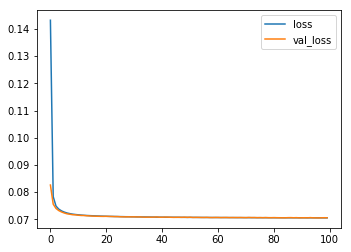

In [178]:
batch_size = 256
epochs = 100
history_callback = model.fit(X_t, Y_t, batch_size=batch_size, epochs=epochs, verbose=2, \
          validation_data=(X_v, Y_v))

# print("Max score %f at epoch %d" % (np.max(scores), np.argmax(scores)))
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_callback.history['loss'])
plt.plot(history_callback.history['val_loss'])
plt.legend(labels=['loss', 'val_loss'])
# plt.subplot(1, 2, 2)
# plt.plot(scores)
# plt.legend(labels=['val_fbeta'])
# plt.show()

In [179]:
pred_v_final = (model.predict(X_v) > 0.2).astype(int)
fbeta_score(Y_v, pred_v_final, beta=2, average='samples')

0.94125291328732319

In [180]:
pred_train_final = (model.predict(X_train) > 0.2).astype(int)
fbeta_score(y_true_train, pred_train_final, beta=2, average='samples')

0.94506739202288514

In [186]:
cls=3
w1=model.get_weights()[0][:,cls].reshape((17,5))
for i in range(17):
    print(w1[i,:])

[-15.0847   -4.06113  -7.57677 -16.78234  -5.39819]
[-0.62543  0.80531 -0.75107 -1.19027  0.14674]
[ -8.88086  -2.84881   7.07265  36.54503  26.58259]
[ 0.44704  0.2467   5.15314  2.4847   1.84196]
[-0.17713 -0.99379  1.01715 -0.82558 -1.23105]
[-2.97537  3.47419 -0.87784 -0.65745 -0.46761]
[-0.19913  0.09611 -0.44161 -0.03633 -0.81241]
[-1.39572 -0.43365 -1.2265  -0.56022  0.01494]
[  2.52688   4.24145  -1.02049  11.44044   0.12588]
[-0.99351 -0.18186 -1.105    0.03765 -0.52204]
[-0.91355  1.76397 -3.20688 -2.0808   2.21245]
[-0.51412 -0.58624  0.27673 -1.12249  0.27859]
[ 2.44586 -1.38619 -0.23896 -1.23565  0.95288]
[-11.06025  -7.47486   2.16442   8.16653   0.74888]
[-0.66162 -0.31268 -1.07015 -1.14211 -0.1778 ]
[-0.32547 -0.33468  0.76427 -0.29174  0.3493 ]
[  2.91964   8.06445  -5.17206  37.90324  22.07038]


In [181]:
def reconstruct(X_r):
    X_r_reconstructed = np.empty((5,X_r.shape[0],17))
    temp1 = X_r.reshape((X_r.shape[0],17,5)).transpose()
    for i in range(temp1.shape[0]):
        X_r_reconstructed[i] = temp1[i].transpose()
    return X_r_reconstructed

In [182]:
p_v_reconstructed = (np.mean(reconstruct(X_v), axis=0) > 0.2).astype(int)
fbeta_score(Y_v, p_v_reconstructed, beta=2, average='samples')

0.94173161452971843

In [183]:
p_t_reconstructed = (np.mean(reconstruct(X_t), axis=0) > 0.2).astype(int)
fbeta_score(Y_t, p_t_reconstructed, beta=2, average='samples')

0.94096011664754398

In [184]:
p_reconstructed = (np.mean(reconstruct(X), axis=0) > 0.2).astype(int)
fbeta_score(Y, p_reconstructed, beta=2, average='samples')

0.94111441765341974

In [173]:
from keras.optimizers import rmsprop
inp = Input(batch_shape=(None, dim_classes*dim_models))
x = Dense(17, activation='sigmoid')(inp)
model2 = Model(inputs=inp, outputs=x)
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 85)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 17)                1462      
Total params: 1,462
Trainable params: 1,462
Non-trainable params: 0
_________________________________________________________________


Train on 259065 samples, validate on 64767 samples
Epoch 1/100
4s - loss: 0.1895 - acc: 0.9483 - val_loss: 0.1005 - val_acc: 0.9705
Epoch 2/100
4s - loss: 0.0890 - acc: 0.9717 - val_loss: 0.0814 - val_acc: 0.9726
Epoch 3/100
4s - loss: 0.0789 - acc: 0.9729 - val_loss: 0.0765 - val_acc: 0.9732
Epoch 4/100
4s - loss: 0.0758 - acc: 0.9733 - val_loss: 0.0747 - val_acc: 0.9735
Epoch 5/100
4s - loss: 0.0745 - acc: 0.9735 - val_loss: 0.0739 - val_acc: 0.9736
Epoch 6/100
4s - loss: 0.0738 - acc: 0.9737 - val_loss: 0.0733 - val_acc: 0.9738
Epoch 7/100
4s - loss: 0.0733 - acc: 0.9738 - val_loss: 0.0729 - val_acc: 0.9738
Epoch 8/100
4s - loss: 0.0729 - acc: 0.9739 - val_loss: 0.0726 - val_acc: 0.9740
Epoch 9/100
4s - loss: 0.0727 - acc: 0.9739 - val_loss: 0.0724 - val_acc: 0.9740
Epoch 10/100
4s - loss: 0.0725 - acc: 0.9740 - val_loss: 0.0723 - val_acc: 0.9740
Epoch 11/100
4s - loss: 0.0723 - acc: 0.9740 - val_loss: 0.0721 - val_acc: 0.9741
Epoch 12/100
4s - loss: 0.0722 - acc: 0.9741 - val_loss:

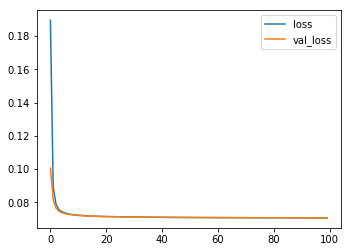

In [174]:
batch_size = 256
epochs = 100
history_callback = model2.fit(X_t, Y_t, batch_size=batch_size, epochs=epochs, verbose=2, \
          validation_data=(X_v, Y_v))

# print("Max score %f at epoch %d" % (np.max(scores), np.argmax(scores)))
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_callback.history['loss'])
plt.plot(history_callback.history['val_loss'])
plt.legend(labels=['loss', 'val_loss'])

In [175]:
pred_v_final = (model2.predict(X_v) > 0.2).astype(int)
fbeta_score(Y_v, pred_v_final, beta=2, average='samples')

0.94116320723963653

In [176]:
pred_train_final = (model2.predict(X_train) > 0.2).astype(int)
fbeta_score(y_true_train, pred_train_final, beta=2, average='samples')

0.94502204382852439